# Instacart Basket Analysis

## 1. Importing Required Libraries

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px

## 2. Loading the Dataset

In [169]:

fact_orders = pd.read_csv(Path("..") / "data" / "processed" / "fact_orders.csv")
fact_order_products_prior = pd.read_csv(Path("..") / "data" / "processed" / "fact_order_products_prior.csv")
fact_order_products = pd.read_csv(Path("..") / "data" / "processed" / "fact_order_products.csv")
dim_aisles = pd.read_csv(Path("..") / "data" / "processed" / "dim_aisles.csv")
dim_products = pd.read_csv(Path("..") / "data" / "processed" / "dim_products.csv")
dim_departments = pd.read_csv(Path("..") / "data" / "processed" / "dim_departments.csv")

## 3. EDA

This analysis schema was adapted from [Exploratory Analysis - Instacart](https://www.kaggle.com/code/philippsp/exploratory-analysis-instacart) by Phillip Spachtholz. I extend my gratitude to Phillip for this exceptional work. As part of my contribution I have delved deeper in some cases to add a more qualitative touch to the analyses.

For more information on the dataset you can refer - https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

With these let's start the analysis !!!

### 1. When do people order ?

#### Hour of Day

Most orders seem to come in from between 8:00-18:00

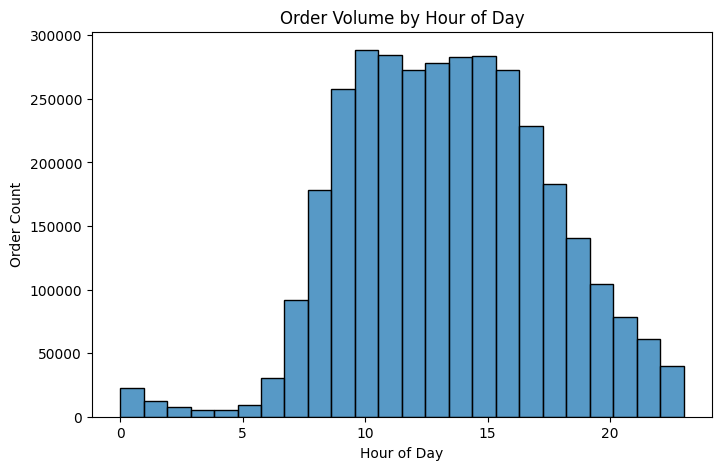

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(fact_orders['order_hour_of_day'], bins=24, color='tab:blue')
plt.title("Order Volume by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Order Count")
plt.show()

#### Day of Week

The order counts on day 0 & 1 are comparitively larger to other days. Unfortunately the dataset doesn't specify the corresponding days. I think its safe to assume they are weekends

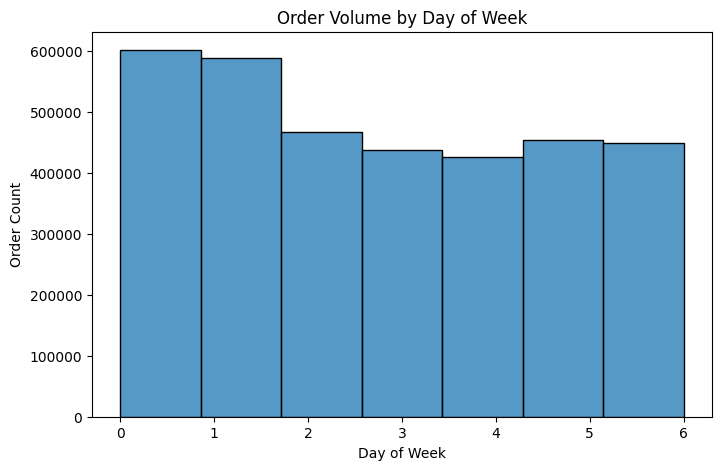

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(fact_orders['order_dow'], bins=7, color='tab:blue')
plt.title("Order Volume by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Order Count")
plt.show()

### 2. How many days since the recent order ?

There appears to be capping for days past 30 and probably that's why it accounts the highest. Asides that people seems to order once in a week

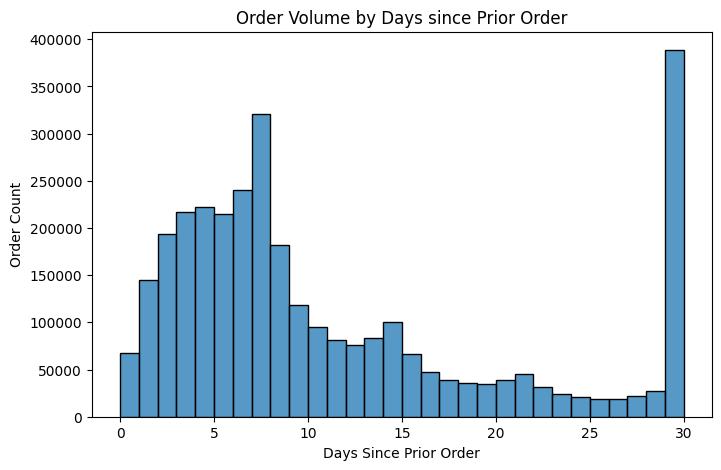

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(fact_orders['days_since_prior_order'], bins=30, color='tab:blue')
plt.title("Order Volume by Days since Prior Order")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Order Count")
plt.show()

### 3. How many prior orders are there ?

Most customers have atleast three prior orders

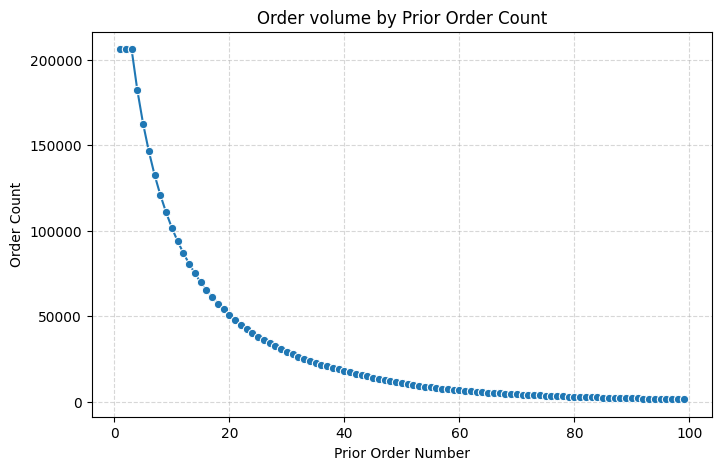

In [ ]:
prior_orders = fact_orders[fact_orders['eval_set'] == 'prior'].groupby('order_number').agg('size').reset_index(name='prior_order_count')
plt.figure(figsize=(8,5))
sns.lineplot(data=prior_orders, x='order_number', y='prior_order_count', marker='o')
plt.title("Order volume by Prior Order Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Prior Order Number")
plt.ylabel("Order Count")

plt.show()

### 4. What is the most common basket size ?

Around 5 is what most people order size looks like. The trend look exponentially decreasing as basket size increases and we even have some very large orders which need to be looked into.

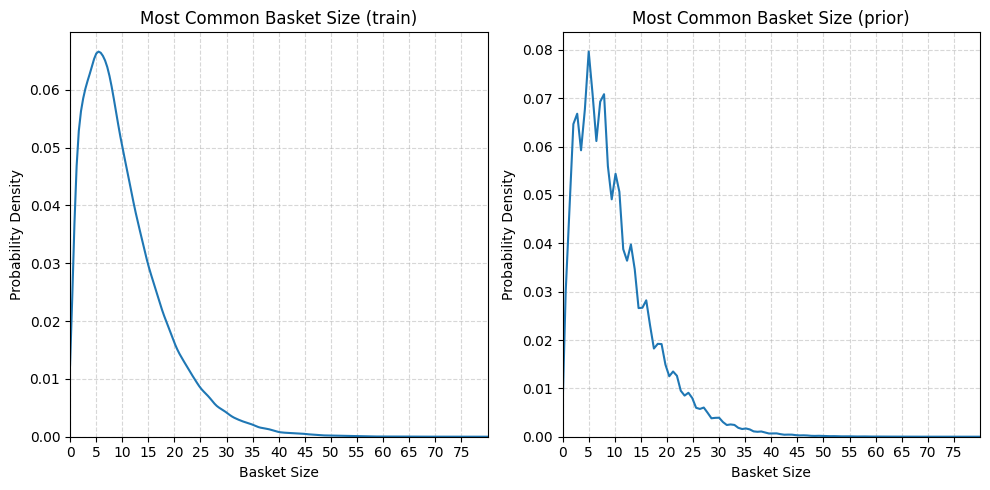

In [ ]:
# taking train data and prior data

basket_size_train = fact_order_products.groupby('order_id')['add_to_cart_order'].agg('max').reset_index()
basket_size_prior = fact_order_products_prior.groupby('order_id')['add_to_cart_order'].agg('max').reset_index()

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plotting first fig
sns.kdeplot(data=basket_size_train['add_to_cart_order'], color='tab:blue', ax=axes[0])
axes[0].set_title("Most Common Basket Size (train)")
axes[0].set_xlabel("Basket Size")
axes[0].set_ylabel("Probability Density")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_xlim(0,80) # contain only basket size > 0
axes[0].set_xticks(np.arange(0,80,5))

# plotting second fig
sns.kdeplot(data=basket_size_prior['add_to_cart_order'], color='tab:blue', ax=axes[1])
axes[1].set_title("Most Common Basket Size (prior)")
axes[1].set_xlabel("Basket Size")
axes[1].set_ylabel("Probability Density")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_xlim(0,80) # contain only basket size > 0
axes[1].set_xticks(np.arange(0,80,5))

plt.tight_layout() # adjust layout to prevent overlapping

plt.show()

### 5. What are the top 10 products sold ?

In [ ]:
top_products = fact_order_products.groupby('product_id').agg('size').reset_index(name='order_count').sort_values(by='order_count', ascending=False)
top_products = top_products.merge(dim_products[['product_id', 'product_name']], on='product_id')
top_products.head(10)

,product_id,order_count,product_name
0,24852,18726,Banana
1,13176,15480,Bag of Organic Bananas
2,21137,10894,Organic Strawberries
3,21903,9784,Organic Baby Spinach
4,47626,8135,Large Lemon
5,47766,7409,Organic Avocado
6,47209,7293,Organic Hass Avocado
7,16797,6494,Strawberries
8,26209,6033,Limes
9,27966,5546,Organic Raspberries


### 6. What is the proportion of reordered orders ?

Reorders constitute to around 60% of the total orders

In [ ]:
reorder_count = fact_order_products.groupby('reordered').agg('size').reset_index(name='order_count')
reorder_count['pct'] = reorder_count['order_count'] / reorder_count['order_count'].sum()
reorder_count

,reordered,order_count,pct
0,0,555793,0.401406
1,1,828824,0.598594


### 7. What are the most frequently reordered products ?

As expected it lines with the top 10 products

In [ ]:
most_reordered = fact_order_products.groupby('product_id')['reordered'].agg('sum').reset_index().sort_values(by='reordered', ascending=False)
most_reordered = most_reordered.merge(dim_products[['product_id', 'product_name']], on='product_id')
most_reordered.head(10)

,product_id,reordered,product_name
0,24852,16557,Banana
1,13176,13362,Bag of Organic Bananas
2,21137,8603,Organic Strawberries
3,21903,8055,Organic Baby Spinach
4,47766,6226,Organic Avocado
5,47209,6042,Organic Hass Avocado
6,47626,5923,Large Lemon
7,16797,4786,Strawberries
8,27966,4279,Organic Raspberries
9,26209,4234,Limes


### 8. Which are the top 10 items added to cart first ?

This time also we can see banannas!!

Its among the top 10 ordered, reordered, first added to cart product

In [ ]:
fact_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
first_item = fact_order_products[fact_order_products['add_to_cart_order'] == 1]
first_item = first_item.groupby('product_id')['add_to_cart_order'].agg('size').reset_index(name='first_time_count').sort_values(by='first_time_count', ascending=False)
first_item = first_item.merge(dim_products[['product_id', 'product_name']], on='product_id')
first_item.head(10)

,product_id,first_time_count,product_name
0,24852,4605,Banana
1,13176,3889,Bag of Organic Bananas
2,27845,1144,Organic Whole Milk
3,47766,995,Organic Avocado
4,21137,900,Organic Strawberries
5,21903,869,Organic Baby Spinach
6,47209,797,Organic Hass Avocado
7,19660,730,Spring Water
8,16797,707,Strawberries
9,44632,647,Sparkling Water Grapefruit


### 9. Association between days since last order and reorder trends

People are more inclined to place reorder on the first seven days following their purchase. However, after a period of 30 days, their purchasing behavior shifts, and they exhibit a greater preference for new products.

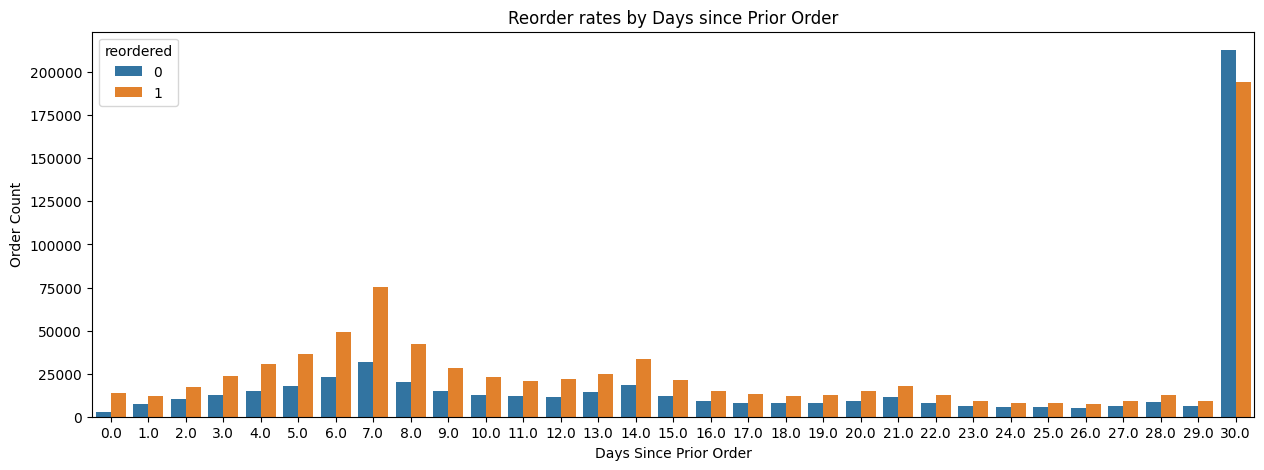

In [ ]:
reorder_by_days_since_prior = fact_order_products.merge(fact_orders[['order_id', 'days_since_prior_order']], on='order_id') # merge to get days since prior order
reorder_by_days_since_prior = reorder_by_days_since_prior.groupby(['days_since_prior_order', 'reordered']).agg('size') # grouping based on days since prior and reordered
reorder_by_days_since_prior = reorder_by_days_since_prior.reset_index(name='order_count')

# Bar Plot 
plt.figure(figsize=(15,5))
sns.barplot(data=reorder_by_days_since_prior, x='days_since_prior_order', y='order_count', hue='reordered')
plt.title("Reorder rates by Days since Prior Order")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Order Count")
plt.show()

### 10. Association between number of orders and probability of reordering

It's seen that very few products have large orders and high reorder rates. This is along expected lines. 

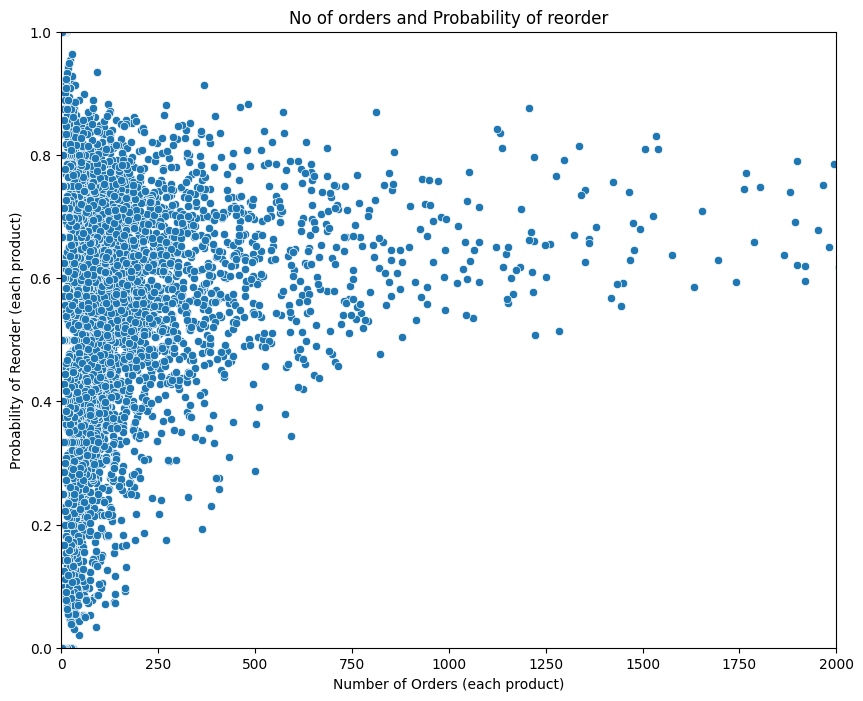

In [53]:
reorder_by_product = fact_order_products.groupby('product_id').agg(prob_reorder=('reordered', 'mean'), cnt_orders=('reordered', 'size')).reset_index()
plt.figure(figsize=(10,8))
plt.title("No of orders and Probability of reorder")
sns.scatterplot(data=reorder_by_product, x='cnt_orders', y='prob_reorder')
plt.xlabel('Number of Orders (each product)')
plt.ylabel("Probability of Reorder (each product)")
plt.xlim(0, 2000)
plt.ylim(0,1)
plt.show()

To do a more reasonable analysis let's focus on products with fewer than 250 orders, as this range encompasses the majority of the products in the dataset.

Yup.... We have got something now. Milk is what most people are likely to reorder along with fruits and breads

In [59]:
reorder_by_product = reorder_by_product[reorder_by_product['cnt_orders'] <= 250].sort_values(by=['prob_reorder', 'cnt_orders'], ascending=[False, True])
reorder_by_product.head(10)

,product_id,prob_reorder,cnt_orders,product_name,cnt_orders_scaled
1374,1729,0.934783,92,2% Lactose Free Milk,0.210
9571,12193,0.898305,59,100% Florida Orange Juice,0.045
16610,21038,0.888889,81,Organic Spelt Tortillas,0.155
100,117,0.883333,120,Petit Suisse Fruit,0.350
28917,36717,0.876543,81,Double Fiber Bread,0.155
7745,9810,0.873418,79,100% Lactose Free 1% Lowfat Milk,0.145
4372,5514,0.872000,125,Organic Homogenized Whole Milk,0.375
18462,23383,0.869565,69,Super Natural Organic Whole Milk,0.095
17863,22610,0.868852,122,Reduced Fat 2% Lactose-Free Milk,0.360
22925,29118,0.863248,117,French Vanilla Soy Creamer,0.335


### 11. Organic v/s Non Organic

#### Percentage of Organic v/s Non Organic Sales

29% sales are organic products

In [75]:
# Create a new boolean column 'organic'
dim_products['organic'] = dim_products['product_name'].str.lower().str.contains('organic')
organic_sales = fact_order_products.merge(dim_products[['product_id', 'product_name', 'organic']], on='product_id')
organic_sales = organic_sales.groupby('organic').agg(cnt=('organic', 'size'), # for each group do the aggregation (size) on organic column
                                              pct=('organic', lambda x: len(x) / len(fact_order_products)))
organic_sales

,cnt,pct
organic,,
False,979000,0.707055
True,405617,0.292945


#### Percentage of Organic v/s Non Organic Reorders

People more often reorder non organic products

In [ ]:
organic_reorder = fact_order_products.merge(dim_products[['product_id', 'product_name', 'organic']], on='product_id')
organic_reorder = organic_reorder[organic_reorder['reordered'] == 1]
organic_reorder = organic_reorder.groupby('organic').agg(cnt=('organic', 'size'), # for each group do the aggregation (size) on organic column
                                              pct=('organic', lambda x: len(x) / len(organic_reorder)))
organic_reorder

,cnt,pct
organic,,
False,566350,0.683318
True,262474,0.316682


### Product Portfolio

In [195]:
product_portfolio = dim_products.groupby(['department_id']).agg('size').reset_index(name='dept_count') # get number of products under each department
product_portfolio = product_portfolio.merge(dim_departments, on='department_id')
product_portfolio = product_portfolio.merge(dim_products, on='department_id')
product_portfolio = product_portfolio.merge(dim_aisles, on='aisle_id')

# Product portfolio treemap
fig = px.treemap(product_portfolio, path=[px.Constant("all"), 'department', 'aisle'], values='dept_count',
                 color='dept_count', color_continuous_scale='blues')
fig.update_traces(root_color="lightblue")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()


### Sales Portfolio

People mostly order fresh fruits, vegetables, dairy and other edibles. The share of other product categories is significantly smaller in comparison.

Additionally, personal care products hold a substantial portion of the inventory. However, their sales are notably low, indicating a potential area for further investigation and optimization.

In [193]:
sales_portfolio = fact_order_products.merge(dim_products, on='product_id').merge(dim_aisles, on='aisle_id').merge(dim_departments, on='department_id')
sales_grouped = sales_portfolio.groupby('department').agg('size').reset_index(name='dept_count') # get number of orders under each department
sales_portfolio = sales_portfolio.merge(sales_grouped, on='department')

# Treemap of sales portfolio
fig = px.treemap(sales_portfolio, path=[px.Constant('all'), 'department', 'aisle'], 
                 color='dept_count', color_continuous_scale='blues')
fig.update_traces(root_color='lightblue')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()